##### CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 5
# Logistic Regression and PCA 

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.linear_model import LinearRegression
# from statsmodels.discrete.discrete_model import Logit
# from statsmodels.discrete.discrete_model import LogitResults
%matplotlib inline



/Applications/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Cancer Classification from Gene Expressions

In this homework assignment, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `dataset_hw5.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following parts, we will use logistic regression to build a classification model for this data set. We will also use principal components analysis (PCA) to visualize the data and to reduce its dimensions. 



## Part (a): Data Exploration

- First step is to split the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).


- Take a peak at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.


- Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?


- A convenient tool to visualize the gene expression data is a heat map. Arrange the rows of the training set so that the 'AML' rows are grouped together and the 'ALL' rows are together. Generate a heat map of the data with expression values from the following genes: 
`D49818_at`, `M23161_at`, `hum_alu_at`, `AFFX-PheX-5_at`, `M15990_at`. By observing the heat map, comment on which of these genes are useful in discriminating between the two classes.


- We can also visualize this data set in two dimensions using PCA. Find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the AML and ALL points in different colors. How well do the top two principal components discriminate between the two classes?



In [2]:
np.random.seed(9001)
df = pd.read_csv('dataset_hw5.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

In [3]:
data_train.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0,-214,-153,-58,88,-295,-558,199,-176,252,...,185,511,-125,389,-37,793,329,36,191,-37
5,0,-67,-93,84,25,-179,-323,-135,-127,-2,...,48,224,60,194,-10,291,41,8,-2,-80
9,0,-476,-213,-18,301,-403,-394,-42,-144,98,...,241,1214,127,255,50,1701,1108,61,525,-83
12,0,17,-229,79,218,-262,-404,325,-201,6,...,225,1020,-109,209,-51,1434,255,53,545,-16
13,0,-144,-199,-157,132,-151,-347,-118,-24,126,...,103,595,-12,36,26,208,113,-8,22,-22


In [4]:
col_names = data_train.columns
min_max_scaler = MinMaxScaler()
data_train = min_max_scaler.fit_transform(data_train)
data_test = min_max_scaler.fit_transform(data_test)

data_train = pd.DataFrame(data_train)
data_test = pd.DataFrame(data_test)
data_train.columns = col_names
data_test.columns = col_names

data_train.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0.0,0.466192,0.596552,0.487535,0.318182,0.369800,0.366279,0.644599,0.644860,0.928074,...,0.488525,0.307918,0.398126,0.363988,0.677778,0.385555,0.322609,0.843750,0.088995,0.570896
1,0.0,0.727758,0.803448,0.684211,0.139205,0.548536,0.707849,0.411847,0.759346,0.338747,...,0.039344,0.097507,0.831382,0.175218,0.777778,0.118959,0.072174,0.746528,0.012316,0.410448
2,0.0,0.000000,0.389655,0.542936,0.923295,0.203390,0.604651,0.476655,0.719626,0.570766,...,0.672131,0.823314,0.988290,0.234269,1.000000,0.867764,1.000000,0.930556,0.221692,0.399254
3,0.0,0.877224,0.334483,0.677285,0.687500,0.420647,0.590116,0.732404,0.586449,0.357309,...,0.619672,0.681085,0.435597,0.189739,0.625926,0.725969,0.258261,0.902778,0.229638,0.649254
4,0.0,0.590747,0.437931,0.350416,0.443182,0.591680,0.672965,0.423693,1.000000,0.635731,...,0.219672,0.369501,0.662763,0.022265,0.911111,0.074881,0.134783,0.690972,0.021851,0.626866


In [5]:
grouped = data_train.groupby('Cancer_type').mean()
interesting_columns = grouped[["D49818_at", "M23161_at", "hum_alu_at", "AFFX-PheX-5_at", "M15990_at"]]
interesting_columns

,D49818_at,M23161_at,hum_alu_at,AFFX-PheX-5_at,M15990_at
Cancer_type,,,,,
0.0,0.504676,0.374248,0.465162,0.55364,0.266351
1.0,0.573192,0.255162,0.530630,0.62931,0.231240


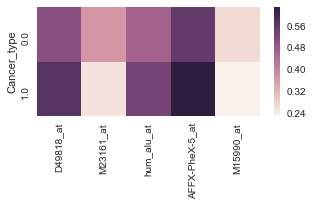

In [6]:
fig, ax = plt.subplots(1,1, figsize=(5,2))
sns.heatmap(interesting_columns, ax=ax)
ax.set_xticklabels(interesting_columns, rotation='vertical')
plt.show()

In [7]:
X_train = data_train.drop("Cancer_type", axis = 1)
y_train = data_train["Cancer_type"]
X_test = data_test.drop("Cancer_type", axis = 1)
y_test = data_test["Cancer_type"]

pca = PCA(n_components=2)
pca.fit(X_train)
X = pca.fit_transform(X_train.values)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print('Explained variance ratio:', pca.explained_variance_ratio_)

Explained variance ratio: [ 0.17206147  0.10732536]


In [8]:
dfpca = pd.DataFrame({"type":data_train.Cancer_type})
for i in range(pca.explained_variance_ratio_.shape[0]):
    dfpca["pc%i" % (i+1)] = X[:,i]
dfpca.head()

,type,pc1,pc2
0,0.0,7.667016,-0.181423
1,0.0,-8.705271,-3.125805
2,0.0,21.341974,8.695750
3,0.0,11.527625,23.669090
4,0.0,-7.842504,7.473373


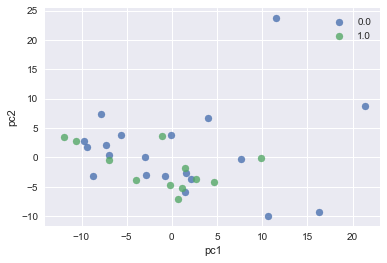

In [9]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
colors = [c0, c1]
for label, color in zip(dfpca['type'].unique(), colors):
    mask = dfpca['type']==label
    plt.scatter(dfpca[mask]['pc1'], dfpca[mask]['pc2'], c=color, label=label, alpha=0.8)
plt.xlabel("pc1")
plt.ylabel("pc2")
plt.legend(loc="best")
plt.show()

## Answer:
### 1. Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?
- We can see that the training set contains 32 rows/observations but more than 7000 columns/predictors. The problem is high dimensionality, where p (predictors) >> n (observations). Plus, many predictors can be correlated.
- Since y only takes two values 0 or 1, $\epsilon$ is not normally distributed.

### 2. By observing the heat map, comment on which of these genes are useful in discriminating between the two classes.
- M23161_at: higher for type 0 (ALL) and lower for type 1 (AML)
- hum_alu_at and AFFX-PheX-5_at: higher for type 1 (AML) and lower for type 0 (ALL)
- The rest of the three genes do not differ a lot so it is hard to use those to distinguish the two classes.

### 3. How well do the top two principal components discriminate between the two classes?
- With only two principal components, the classification is not very clear. But we can still see that most "type 1" (AML) points stay in the lower left corner.
- To get a better discrimination between two classes, we need more prinicpal components. The current two dimensions are not enough.

## Part (b): Linear Regression vs. Logistic Regression

Begin by analyzing the differences between using linear regression and logistic regression for classification. For this part, you shall work with a single gene predictor: `D29963_at`.

- Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by regression model interpreted for a patient as an estimate of the probability that the patient has the `ALL` type cancer (class 1). Is there a problem with this interpretation?


- The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into the `ALL` type (class 1), and the others into the `AML` type (class 0). Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.


- Next, fit a simple logistic regression model to the training set. How does the training and test calssification accuracy of this model compare with the linear regression model?  Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order not to regularize (use 'C=100000').



- Plot the quantitative output from linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot.
Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.



In [10]:
X_train = sm.add_constant(data_train["D29963_at"])
X_test = sm.add_constant(data_test["D29963_at"])
y_train = data_train["Cancer_type"].values.reshape(-1,1)
y_test = data_test["Cancer_type"].values.reshape(-1,1)

model = OLS(endog=y_train, exog=X_train)
result = model.fit()

y_hat_train = result.predict()
y_hat_test = result.predict(exog=X_test)

print(y_hat_train)
print(y_hat_test)

[ 0.32341262  0.20860616  0.39471348  0.43096815  0.39833895  0.32945507
  0.3963248   0.32864941  0.43902475  0.32703809  0.46722283  0.41525779
  0.28030984  0.34516542  0.41203516  0.39914461  0.68716784  0.15623829
  0.13569398  0.13126285  0.41445213  0.29884001  0.34959655  0.18645052
  0.88213742  0.50831146  0.37416916  0.51878503  0.29843718  0.36893238
  0.20054956  0.59330852]
0     0.404051
1     0.295572
2     0.348928
3     0.499103
4     0.302992
5     0.271544
6     0.365536
7     0.258470
8     0.251049
9     0.437973
10    0.401224
11    0.504757
12    0.415005
13    0.249989
14    0.331614
15    0.328434
16    0.241509
17    0.882137
18    0.425252
19    0.307586
20    0.449280
21    0.852456
22    0.511470
23    0.613236
24    0.332321
25    0.221368
26    0.377196
27    0.317126
28    0.209000
29    0.131263
30    0.135150
31    0.249283
32    0.280378
33    0.297339
34    0.283205
35    0.530905
36    0.336207
37    0.393451
38    0.545746
39    0.603342
40    0.7

In [11]:
y_hat_train[y_hat_train > 0.5] = 1
y_hat_train[y_hat_train <= 0.5] = 0
# print(y_train.reshape(32,))
# print(y_hat_train)
# print(y_train.reshape(32,) - y_hat_train)
accuracy_train = np.mean( y_train.reshape(32,) == y_hat_train )
print("The classification accuracy for the training set using linear regression is:", accuracy_train)
y_hat_test = y_hat_test.values
y_hat_test
y_hat_test[y_hat_test > 0.5] = 1
y_hat_test[y_hat_test <= 0.5] = 0
accuracy_test = np.mean( y_test.reshape(41, ) == y_hat_test )
# print(y_hat_test)
# print(y_test.reshape(41, ))
print("The classification accuracy for the test set using linear regression is:", accuracy_test)

The classification accuracy for the training set using linear regression is: 0.71875
The classification accuracy for the test set using linear regression is: 0.853658536585


In [12]:
logitm = LogisticRegression(C = 100000)
logitm.fit (X_train, data_train["Cancer_type"])
y_hat_train_log = logitm.predict(X_train)
accuracy_train_log = np.mean( y_train.reshape(32,) == y_hat_train_log )
print("The classification accuracy for the training set using logistic regression is:", accuracy_train_log)

y_hat_test_log = logitm.predict(X_test)
accuracy_test_log = np.mean( y_test.reshape(41,) == y_hat_test_log )
print("The classification accuracy for the test set using logistic regression is:", accuracy_test_log)

The classification accuracy for the training set using logistic regression is: 0.71875
The classification accuracy for the test set using logistic regression is: 0.829268292683


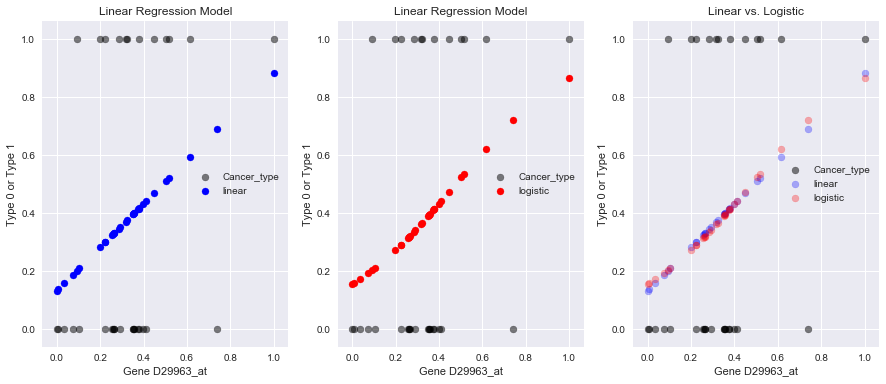

In [13]:
X= data_train["D29963_at"]
lm = LinearRegression()
lm.fit (X_train, data_train["Cancer_type"])

# plt.scatter(data_train["D29963_at"], data_train["Cancer_type"], color = "black", alpha=0.3)
# plt.scatter(X, lm.predict(X_train), color="blue", alpha=0.5, label="linear")
# plt.scatter(X, logitm.predict_proba(X_train)[:,1],  color='red', alpha=0.5, label="logistic")
# plt.xlabel ("Gene D29963_at")
# plt.ylabel("Type 0 or Type 1")    
# plt.legend(loc='best')
# plt.show()

fig, axes = plt.subplots(1,3,figsize=(15,6))
axes[0].scatter(data_train["D29963_at"], data_train["Cancer_type"], color = "black", alpha=0.5)
axes[0].scatter(X, lm.predict(X_train), color="blue", label="linear")
axes[0].set_xlabel("Gene D29963_at")
axes[0].set_ylabel("Type 0 or Type 1")
axes[0].set_title("Linear Regression Model")
axes[0].legend(loc='best')

axes[1].scatter(data_train["D29963_at"], data_train["Cancer_type"], color = "black", alpha=0.5)
axes[1].scatter(X, logitm.predict_proba(X_train)[:,1], color="red", label="logistic")
axes[1].set_xlabel("Gene D29963_at")
axes[1].set_ylabel("Type 0 or Type 1")
axes[1].set_title("Linear Regression Model")
axes[1].legend(loc='best')

axes[2].scatter(data_train["D29963_at"], data_train["Cancer_type"], color = "black", alpha=0.5)
axes[2].scatter(X, lm.predict(X_train), color="blue", label="linear", alpha=0.3)
axes[2].scatter(X, logitm.predict_proba(X_train)[:,1], color="red", label="logistic", alpha=0.3)
axes[2].set_xlabel("Gene D29963_at")
axes[2].set_ylabel("Type 0 or Type 1")
axes[2].set_title("Linear vs. Logistic")
axes[2].legend(loc='best')
plt.show()

## Answer:
### 1.  Is there a problem with this interpretation?
- Yes. It is possible that linear regression gives negative values or values above 1, which makes no sense in probablity.

### 2. How does the training and test calssification accuracy of this model compare with the linear regression model?
- The accuracy rate for the training set doesn't change from linear regression to logistic regression. The accuracy for the test set decreases a little bit, but does not differ much.

### 3. Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.
- From the plot, we can see the probability outputs from both linear model and logistic model are very close to each other, so it is hard to say which model is better.
- We can see the logistic model has a sigmoid shape.
- Generally, logistic regression is better for binary classification.

## Part (c): Multiple Logistic Regression

Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in Part (b) with a single gene (on both the training and test sets)?  

Use the `visualize_prob` from `HW5_functions.py` to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the `ALL` and `AML` classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line.  Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

In [14]:
X_train = data_train.drop("Cancer_type", axis = 1)
X_test = data_test.drop("Cancer_type", axis = 1)
y_train = data_train["Cancer_type"].values
y_test = data_test["Cancer_type"].values

logitm = LogisticRegression(C = 100000)
logitm.fit (X_train, data_train["Cancer_type"])
# y_hat_train_log2 = logitm.predict(X_train)
# accuracy_train_log2 = np.mean( y_train == y_hat_train_log2 )
accuracy_train_log2 = logitm.score(X_train, data_train["Cancer_type"])
print("The training accuracy using logistic regression with all gene predictors is:", accuracy_train_log2)

# y_hat_test_log2 = logitm.predict(X_test)
# accuracy_test_log2 = np.mean( y_test == y_hat_test_log2 )
accuracy_test_log2 = logitm.score(X_test, data_test["Cancer_type"])
print("The test accuracy using logistic regression with all gene predictors is:", accuracy_test_log2)

The training accuracy using logistic regression with all gene predictors is: 1.0
The test accuracy using logistic regression with all gene predictors is: 0.926829268293


In [15]:
# starter code
from HW5_functions import visualize_prob

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.]


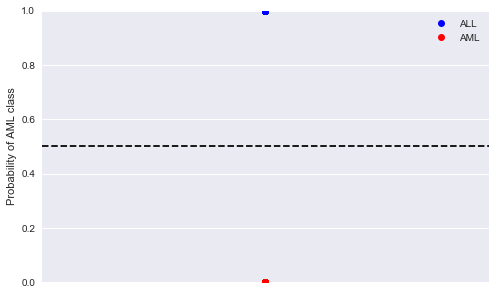

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
visualize_prob(logitm, X_train, y_train, ax)
print(y_train)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  1.  1.  1.  1.  1.]


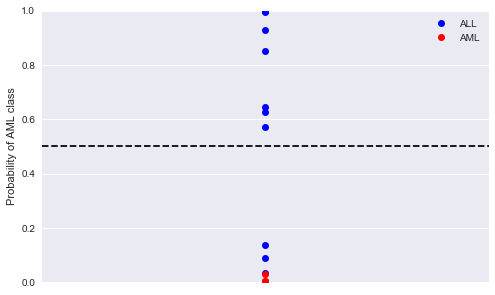

In [17]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
visualize_prob(logitm, X_test, y_test, ax)
print(y_test)

## Answer:
### 1. How does the classification accuracy of this model compare with the models fitted in Part (b) with a single gene (on both the training and test sets)?
- More predictors improved the accuracy on both training and test sets, compared to part(b) with a single gene predictor. We can see that training set is perfectly classified, and test set has accuracy rate about 92.7%. 
- There might be a problem of overfitting with so many predictors.

### 2.  Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?
- For the training set, the spread of probabilities is either 0 or 1. For the test set, we can see the probabilites vary between 0 and 1.
- For the test set, there is a few data points just a little bit above 0.5. This means based on the model we choose, we are not very sure which category we should classify those data points.

## Part (d): Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a *significance level of 95%*? 

Hint: To answer this question, use *bootstrapping* with 100 boostrap samples/iterations.  



In [18]:
# def sample(x, y, k):
#     n = x.shape[0] # No. of training points 
#     # Choose random indices of size 'k'
#     subset_ind = np.random.choice(np.arange(n), k) 
#     # Get predictors and reponses with the indices
#     x_subset = x[subset_ind, :]
#     y_subset = y[subset_ind]  
#     return (x_subset, y_subset)

X_train = data_train.drop("Cancer_type", axis = 1)
X_test = data_test.drop("Cancer_type", axis = 1)
y_train = data_train["Cancer_type"].values
y_test = data_test["Cancer_type"].values


# indexes=np.sort(np.random.choice(X_train.shape[0], size=100, replace=True))
# X_train_boot = X_train[indexes]
# y_train_boot = y_train[indexes]


# X_train_boot = sample(X_train,y_train,100)[0]
# y_train_boot = sample(X_train,y_train,100)[1].reshape(100, )

# logitm = LogisticRegression(C = 100000)
# logitm.fit(X_train_boot, y_train_boot)
# logitm.coef_

# coef = np.empty([100,7129])
# for i in range(100):
#     X_train_boot = sample(X_train,y_train,100)[0]
#     y_train_boot = sample(X_train,y_train,100)[1].reshape(100, )
    
#     logitm = LogisticRegression(C = 100000)
#     logitm.fit(X_train_boot, y_train_boot)
    
#     coef[i,:] = logitm.coef_
# coef.shape

X_train_m = sm.add_constant(X_train)
X_test_m = sm.add_constant(X_test)


boot_coefs = np.zeros((X_train.shape[1]+1,100))
for i in range(100):
    #Your code goes here
    sample_index = np.random.choice(range(len(y_train)), size=len(y_train), replace=True)
    X_train_samples = X_train_m.values[sample_index]
    y_train_samples = y_train[sample_index]
    
    logistic_mod_boot = LogisticRegression(C=100000, fit_intercept=True)
    logistic_mod_boot.fit(X_train_samples, y_train_samples)
    boot_coefs[:,i] = logistic_mod_boot.coef_

boot_coefs.shape

(7130, 100)

In [19]:
ci_upper = np.percentile(boot_coefs, 97.5, axis=1)
ci_lower = np.percentile(boot_coefs, 2.5, axis=1)

# ct significant predictors
sig_b_ct = 0
sig_cols = [0]*7129


# if ci contains 0, then insignificant
for i in range(len(ci_upper)):
    if ci_upper[i]<0 or ci_lower[i]>0:
        sig_b_ct += 1
        sig_cols[i] = 1

print("Significant coefficents at 5pct level = %i / %i" % (sig_b_ct, X_train.shape[1]))

Significant coefficents at 5pct level = 1945 / 7129


In [20]:
indices = [i for i, x in enumerate(sig_cols) if x == 1]
X_train_sig = data_train.iloc[:,indices]
X_test_sig = data_test.iloc[:,indices]

logitm = LogisticRegression(C = 100000)
logitm.fit (X_train_sig, data_train["Cancer_type"])
accuracy_train_log_sig = logitm.score(X_train_sig, data_train["Cancer_type"])
print("The training accuracy using logistic regression with significant gene predictors is:", accuracy_train_log_sig)

# y_hat_test_log2 = logitm.predict(X_test)
# accuracy_test_log2 = np.mean( y_test == y_hat_test_log2 )
accuracy_test_log_sig = logitm.score(X_test_sig, data_test["Cancer_type"])
print("The test accuracy using logistic regression with significant gene predictors is:", accuracy_test_log_sig)

The training accuracy using logistic regression with significant gene predictors is: 1.0
The test accuracy using logistic regression with significant gene predictors is: 0.951219512195


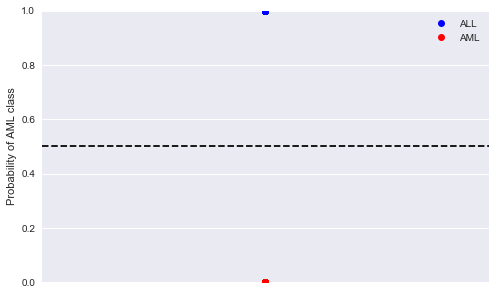

In [21]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
visualize_prob(logitm, X_train_sig, data_train["Cancer_type"], ax)

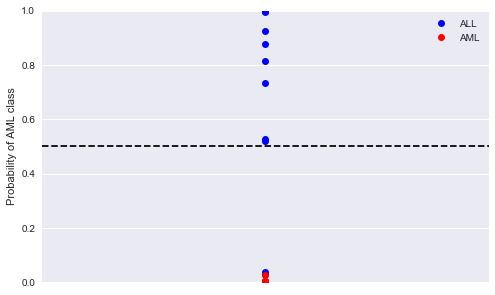

In [22]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
visualize_prob(logitm, X_test_sig, data_test["Cancer_type"], ax)

## Part (e): Dimensionality Reduction using PCA

A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the first set of principal components contributing to 90% of the variance in the predictors.

- Fit the model on PCA components mentioned above.  How do the classification accuracy values on both the training and tests sets compare with the models fitted in Parts (c) and (d)?  

- Re-fit a logistic regression model using 5-fold cross-validation to choose the number of principal components that maximizes accuracy, and comment on whether you get better test performance than the model fitted above (explain your observations). 

- Use the code provided in Part (c) to visualize the probabilities predicted by the fitted models on both the training and test sets. How does the spread of probabilities in these plots compare to those for the models in Part (c) and (d)? 


In [23]:
pca_2 = PCA(n_components=24)
pca_2.fit(X_train)

X_train_pca_2 = pca_2.transform(X_train)
X_test_pca_2 = pca_2.transform(X_test)
print("Variance explained by each PCA component is:\n", pca_2.explained_variance_ratio_)
print("Total variance explained is: ", pca_2.explained_variance_ratio_.sum())

dfpca_2 = pd.DataFrame({"Cancer_type":data_train.Cancer_type})
for i in range(pca_2.explained_variance_ratio_.shape[0]):
    dfpca_2["pc%i" % (i+1)] = X_train_pca_2[:,i]
# dfpca_2.head()

X_train_pca = dfpca_2.drop("Cancer_type", axis = 1)

logitm = LogisticRegression(C = 100000)
logitm.fit(X_train_pca, dfpca_2["Cancer_type"])

accuracy_train_log_pca = logitm.score(X_train_pca, dfpca_2["Cancer_type"])
print("The training accuracy using PCA components is:", accuracy_train_log_pca)

accuracy_test_log_pca = logitm.score(X_test_pca_2, data_test["Cancer_type"])
print("The test accuracy using PCA components is:", accuracy_test_log_pca)

Variance explained by each PCA component is:
 [ 0.17206147  0.10732536  0.06244705  0.05185063  0.04455822  0.04150351
  0.03988679  0.03557932  0.03268542  0.03111699  0.02861302  0.02544972
  0.02438282  0.02302787  0.0218069   0.02154751  0.02075603  0.02030513
  0.01991468  0.01824879  0.01801269  0.01730103  0.01663413  0.0157946 ]
Total variance explained is:  0.910809658552
The training accuracy using PCA components is: 1.0
The test accuracy using PCA components is: 0.926829268293


In [24]:
accuracy_train_logcv = []
accuracy_test_logcv = []
for n in range(1,25):
    pca = PCA(n_components=n)
    pca.fit(X_train)

    X_train_pca_2 = pca.transform(X_train)
    X_test_pca_2 = pca.transform(X_test)

#     print(pca.explained_variance_ratio_.sum())

    dfpca_2 = pd.DataFrame({"Cancer_type":data_train.Cancer_type})
    for i in range(pca.explained_variance_ratio_.shape[0]):
        dfpca_2["pc%i" % (i+1)] = X_train_pca_2[:,i]

    X_train_pca = dfpca_2.drop("Cancer_type", axis = 1)
    logcvm = LogisticRegressionCV(Cs=[100000],cv=5)
    logcvm.fit(X_train_pca, dfpca_2["Cancer_type"])
    
    accuracy_train_logcv.append(logcvm.score(X_train_pca, dfpca_2["Cancer_type"]))
    accuracy_test_logcv.append(logcvm.score(X_test_pca_2, data_test["Cancer_type"]))

#     accuracy_train_logcv = logcvm.score(X_train_pca, dfpca_2["Cancer_type"])
#     print("The training accuracy using PCA components is:", accuracy_train_logcv)
#     accuracy_test_logcv = logcvm.score(X_test_pca_2, data_test["Cancer_type"])
#     print("The test accuracy using PCA components is:", accuracy_test_logcv)
print("Accuracy rate for training set using 1 to 25 pca components: \n", accuracy_train_logcv)
print("Accuracy rate for test set using 1 to 25 pca components: \n", accuracy_test_logcv)
best_pca = accuracy_test_logcv.index(max(accuracy_test_logcv)) + 1
print("Best number of PCA components is: ", best_pca)

Accuracy rate for training set using 1 to 25 pca components: 
 [0.625, 0.65625, 0.84375, 0.9375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Accuracy rate for test set using 1 to 25 pca components: 
 [0.68292682926829273, 0.68292682926829273, 0.75609756097560976, 0.78048780487804881, 0.78048780487804881, 0.75609756097560976, 0.78048780487804881, 0.80487804878048785, 0.75609756097560976, 0.85365853658536583, 0.95121951219512191, 0.95121951219512191, 0.92682926829268297, 0.92682926829268297, 0.90243902439024393, 0.95121951219512191, 0.92682926829268297, 0.92682926829268297, 0.92682926829268297, 0.92682926829268297, 0.92682926829268297, 0.90243902439024393, 0.92682926829268297, 0.90243902439024393]
Best number of PCA components is:  11


In [25]:
pca_2 = PCA(n_components=best_pca)
pca_2.fit(X_train)

X_train_pca_2 = pca_2.transform(X_train)
X_test_pca_2 = pca_2.transform(X_test)
print("Variance explained by each PCA component is:\n", pca_2.explained_variance_ratio_)
print("Total variance explained is: ", pca_2.explained_variance_ratio_.sum())

dfpca_2 = pd.DataFrame({"Cancer_type":data_train.Cancer_type})
for i in range(pca_2.explained_variance_ratio_.shape[0]):
    dfpca_2["pc%i" % (i+1)] = X_train_pca_2[:,i]
# dfpca_2.head()

X_train_pca = dfpca_2.drop("Cancer_type", axis = 1)

logitm = LogisticRegression(C = 100000)
logitm.fit(X_train_pca, dfpca_2["Cancer_type"])

print("The best number of PCA components is:", best_pca)

accuracy_train_log_pca = logitm.score(X_train_pca, dfpca_2["Cancer_type"])
print("The training accuracy using PCA components is:", accuracy_train_log_pca)

accuracy_test_log_pca = logitm.score(X_test_pca_2, data_test["Cancer_type"])
print("The test accuracy using PCA components is:", accuracy_test_log_pca)

Variance explained by each PCA component is:
 [ 0.17206147  0.10732536  0.06244691  0.0518492   0.04455547  0.04149966
  0.03988327  0.03554202  0.03267901  0.03110275  0.02857014]
Total variance explained is:  0.647515268355
The best number of PCA components is: 11
The training accuracy using PCA components is: 1.0
The test accuracy using PCA components is: 0.951219512195


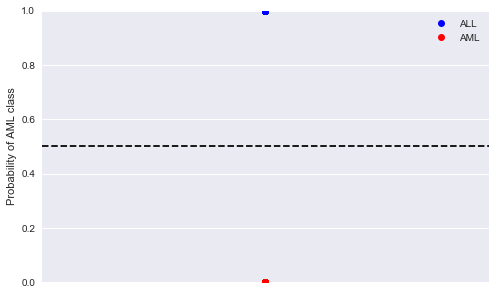

In [26]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
visualize_prob(logitm, X_train_pca, data_train["Cancer_type"], ax)

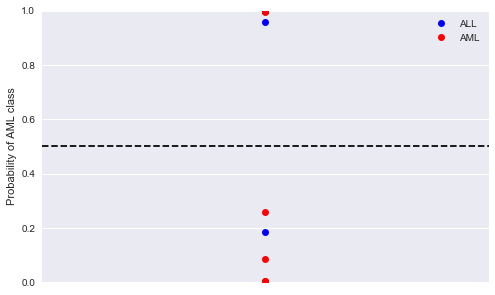

In [27]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
visualize_prob(logitm, X_test_pca_2, data_test["Cancer_type"], ax)

## Answer:

### 1. How do the classification accuracy values on both the training and tests sets compare with the models fitted in Parts (c) and (d)?
- With the set of principal components contributing to 90% of the variance, we get 100% accuracy on the training set, and 92.68% on the test set. For the training score, every model has 1.0. For the test score, this is better than the simple logistic regression, and about the same the multiple logistic regression with all genes in (c), and the same as using all significant predictors in (d).


### 2. Comment on whether you get better test performance than the model fitted above (explain your observations).
- With 11 principal components, the accuracy of the test set even improves more to 95.12%. With this set of principal components contributing to about 64.7% variance rather than 90% as before, it is already enough to do very good classification.


### 3. How does the spread of probabilities in these plots compare to those for the models in Part (c) and (d)?
- Using 11 PCA components, there are no more probabilities that are close to 0.5; probabilities move towards the two ends. However, previously using simple linear regression, simple logistic regression and multiple logistic regression in part (c) and (d), we had predicted probabilities close to 0.5.

---
 

# APCOMP209a - Homework Question

Suppose we want to conduct PCA on the model matrix $X \in \Re^{n×p}$, where the columns have been suitably set to zero mean. In this question, we consider the squared reconstruction error:

$$  \parallel XQ- XQ_m \parallel ^2 $$

for a suitable set of eigenvectors forming the matrix $Q_m$, as discussed below. Suppose that we conduct eigendecomposition of $X^T X$ and obtain eigenvalues $\lambda_1, \ldots , \lambda_p$ and principal components $Q$, i.e.

$$ X^T X = Q \Lambda Q ^T $$

(1) Suppose that the matrix norm is simply the squared dot product, namely

$$ \parallel A \parallel ^2 = A^T A $$

Then, express the reconstruction error as a sum of matrix products.

(2) Simplify your result from (1) based on properties of the matrices $Q$.

(3) Now let $Q_m$ be the matrix of the first $m < p$ eigenvectors, namely

$$ Q_m = (q_1, \ldots, q_m, 0, \ldots, 0) \in \Re^{p \times p} $$

Thus, $X Q_m$ is the PCA projection of the data into the space spanned by the first $m$ principal components. Express the products $Q^T_m Q$ and $Q^T Q_m$, again using properties of the eigenbasis $q_1, \ldots, q_p$.

(4) Use your results from (3) to finally fully simplify your expression from (2).

(5) Note that the result you obtain should still be a matrix, i.e. this does not define a proper norm on the space of matrices (since the value should be a scalar). Consequently, the true matrix norm is actually the trace of the
above result, namely

$$ \parallel A \parallel ^2  = {\rm trace} (A^T A) $$
Use your result from (4) and this new definition to find a simple expression
for the reconstruction error in terms of the eigenvalues.

(6) Interpret your result from (5). In light of your results, does our procedure for PCA (selecting the $m$ substantially larger eigenvalues) make sense? Why or why not?

## Answer:

### (1) Express the reconstruction error as a sum of matrix products.
$$
\begin{aligned}
\parallel XQ- XQ_m \parallel ^2  &= (XQ - XQ_m)^T (XQ - XQ_m) \\
&= [(XQ)^T - (XQ_m)^T](XQ -XQ_m) \\
&= (Q^T X^T - Q_m^T X^T)(XQ - XQ_m) \\
&= (Q^T - Q_m ^T) X^T X (Q - Q_m) \\
&= (Q - Q_m) ^T X^T X (Q -  Q_m)
\end{aligned}
$$

### (2) Simplify your result from (1) based on properties of the matrices  Q .

Note that $Q^T Q = I_p$
$$
\begin{aligned}
(Q - Q_m) ^T X^T X (Q -  Q_m) & = (Q - Q_m) ^T Q \Lambda Q^T(Q -  Q_m) \\
&= (Q^T Q - Q_m ^T Q) \Lambda (Q^T Q - Q^T Q_m) \\
&= (I_p - Q_m ^T Q) \Lambda (I_p - Q^T Q_m)
\end{aligned}
$$

### (3) Express the products $Q^T_m Q$ and $Q^T Q_m$, again using properties of the eigenbasis $q_1, \ldots, q_p$.

$q_1, \ldots, q_p$ is an orthonormal base of eigenvectors.

Therefore, $Q^T_m Q$ and $Q^T Q_m$ are botn an identity matrix $I_m$ augmented to a $p \times p$ matrix, where the rest of elements are zero.

### (4) Use your results from (3) to finally fully simplify your expression from (2).

$I_p - Q_m ^T Q = I_p - Q ^T Q_m$, which is an $p \times p$ matrix where the right bottom part is a $(p-m) \times (p-m)$ identity matrix, and all the rest of elements are zero. Therefore, we have

$$ (I_p - Q_m ^T Q) \Lambda (I_p - Q^T Q_m) =
\begin{bmatrix}
0 & & & & & \\
& \ddots & & & & \\
& & 0 & & & \\
& & & \lambda_{m+1} & & \\
& & & & \ddots & \\
& & & & & \lambda_p
\end{bmatrix} $$

### (5) Use your result from (4) and this new definition to find a simple expression for the reconstruction error in terms of the eigenvalues.

$$\parallel XQ- XQ_m \parallel ^2 = \lambda_{m+1} + \cdots + \lambda_{p}$$

### (6) Interpret your result from (5). In light of your results, does our procedure for PCA (selecting the  m  substantially larger eigenvalues) make sense? Why or why not?

This makes sense because we selece the m substantially larger eigenvalues, and hence the rest of the eigen values from $\lambda_{m+1}$ to $\lambda_p$ are small and therefore we minimize the squared reconstruction error.